### Dataset - CIFAR10

Let's first prepare the data from CIFAR10 dataset.

Source: http://www.cs.utoronto.ca/~kriz/cifar.html

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. 

(we will be using batch_1 only out of 6 batches -- so 10,000 images in total)

The classes are ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

| no. of Classes    | 10            |
|-------------------|---------------|
| Samples per class | ~1,000        |
| Samples total     | 10,000        |
| Dimensionality    | 32x32x3 = 3,072|
| Features          | int 0-255 each pixel     |


In [174]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [175]:
%%html
<style>
table {float:left}
</style>

In [176]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [177]:
# source: http://www.cs.utoronto.ca/~kriz/cifar.html
# get the training data, batch 1 out of 6. do unzip the tar.gz first
cifar = unpickle('cifar\data_batch_1')

In [179]:
for k in cifar.keys():
    print k
    print cifar[k][0]

data
[ 59  43  50 ..., 140  84  72]
labels
6
batch_label
t
filenames
leptodactylus_pentadactylus_s_000004.png


array_size = 3072
[255 255 255 ..., 145 145 145]
file_name = station_wagon_s_000061.png


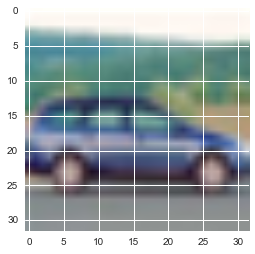

In [191]:
# image data is uint8 array format 
# 3 RGB channels and 32x32 pixels means 32x32x3 = 1024x3 = 3072 numbers in one array
# 10,000 arrays in dataset
lucky_num = randint(0,10000)
sample_image = cifar["data"][lucky_num].copy()
print 'array_size = {}'.format(len(sample_image))
print sample_image
print 'file_name = {}'.format(cifar["filenames"][lucky_num])
#show image
plt.rcParams['figure.figsize'] = (4, 4)
im = sample_image.reshape((32,32,3),order='F')/255.0
im = np.transpose(im,axes=(1,0,2))
plt.imshow(im)
plt.show()

# Convolutional Neural Networks (CNN)

Source: http://cs231n.github.io/convolutional-networks/

Source2: http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html

This is essential normal neural nets with the "Convolution" part to transform raw input into meaningful features. Most common image, video, or other "dense" input problem.

### What is convolution anyways?

The math definition is: "the integral of 2 products after one is reversed and shifted."

$$ (f * g)(t) = \int_{-\infty}^{\infty} f(x) \cdot g(t - x) \; dx  $$

This image from wiki is much easier to understand.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/512px-Comparison_convolution_correlation.svg.png"  title="source is wiki" style="width:500px;" />

In matrix form, below is how to convolve an input matrix with another matrix (called a kernel). 

The convolution is essentially an element-wise multiplication and then sum of the result.

Here we have a 5x5 (green) input matrix and a 3x3 (orange) kernel, doing a 1-each stride (moving the kernel 1 cell a a time). 

<img src="http://i.stack.imgur.com/I7DBr.gif" title="unknown source" style="width:400px;" />


Even more useful is to look at how it was applied in real application. 

The most (visually) obvious is as [a filter in photo editor -- Edge detection, Blur, etc](http://docs.gimp.org/en/plug-in-convmatrix.html). The kernel is mostly a mask (cell value either 1 or 0) to enhance or hide away features.

<img src="http://i1.wp.com/timdettmers.com/wp-content/uploads/2015/03/convolution.png" title="source is timdettmers.com" style="width:400px;" />

So we know what convolution is now (roughly), let's move on to CNN architecture.

## CNN architecture

We're going to use the structure from [here](http://cs231n.github.io/convolutional-networks/). The source website actually contains a great explanation of many concepts, so I will only do a summary.

+ **INPUT** - [32x32x3] - will hold the raw pixel values of the image with 3 color channels.
+ **CONV** - [32x32x12] - this layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as  if we decided to use 12 filters.
+ **RELU** - [32x32x12] - layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged.
+ **POOL** - [16x16x12] - layer will perform a downsampling operation along the spatial dimensions (width, height).
+ **FC** - [1x1x10] - (i.e. fully-connected) layer will compute the class scores, where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. 

Let's get into details of each layer.

### INPUT layer

Not much to be said here. we will use an image matrix of [X,Y,RGB] = [32,32,3].

### CONV layer

First, we will use a filter (aka. kernel) matrix of 3x3xRGB. 

In terms of neurons, the no. of weight (connection) for each filter is 3x3x3 + 1 bias = 28. 

Since we will have 12 filter slices (also called "depth"), we will have 28x12 = 336 connections total for **CONV** layer.

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" title="source from stanford course" style="width:300px;" />

The formula belows calculate the shape of the output matrix. 

For input **W**idth (or height) = 32, **F**ilter width = 3, zero-**P**adding = 1, and **S**tride = 1 :

$$ 
\begin{align}
{Output}& = \dfrac{(W + 2 \cdot P - F)}{S} + 1 \\
{Output}& = \dfrac{(32 + 2 \cdot 1 - 3)}{1} + 1 = 32
\end{align}
$$

So our output matrix from this layer is [32x32x12].

### RELU layer

we will do a Rectified Linear Unit (ReLU) function here. The output will be the same dimension of [32x32x12].

$$ f(x) = max(0,x) $$


### POOL layer

Downsampling from [32x32x12] to [16x16x12].

We are going to use a max function of 2x2 matrix inside the 32x32 layer, therefore the output will be half to [16x16x12]

### FC layer

This is a normal NN output layer, connecting all [16x16x12] input to [1x1x10] predicted output.

We are going to use [Softmax function](https://en.wikipedia.org/wiki/Softmax_function) to constrain all the probability output.

$$ \sigma(f_{out}) = \cfrac{e^{f_{out,i}}}{ \sum_{j=0}^m e^{f_{out,j}} } $$

However, there is a chance that $ e^{f}$ becomes very large, which could make the computer croak by dividing two large numbers. 

The solution is we can add a constant $ \log C$ to both numerator and divisor, so the output magnitude is reasonable.

$$ \sigma(f_{out}) = \cfrac{e^{f_{out,i} + \log C}}{ \sum_{j=0}^m e^{f_{out,j} + \log C} } $$

$$ \log C = -\max f_{out,j} $$

## Loss function

Base on [Softmax Classifier](http://cs231n.github.io/linear-classify/#softmax), the loss function is like so:

$$ L_i = -\log\left(\cfrac{e^{f_{out,i}}}{ \sum_{j=0}^m e^{out,j} }\right) $$

## To be continued...